In [199]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [38]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation:

sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

hf_ord = collect(1:chemical_data.N_spt)

opsum = GenOpSum(chemical_data, hf_ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.015259582318
Expected particle number: 10
Particle number: 10.0


In [4]:
Ipq = MutualInformation(psi, chemical_data, dim=4);

display(Ipq)

7×7 Matrix{Float64}:
 0.0         1.01114e-5  2.12589e-6   1.82147e-6  …  1.28968e-6  4.49479e-6
 1.01114e-5  0.0         0.0082512    0.0099387      0.0110517   0.00877769
 2.12589e-6  0.0082512   0.0          0.031292       0.0449184   0.0731334
 1.82147e-6  0.0099387   0.031292     0.0            0.0477284   0.0311184
 8.19607e-7  0.00026529  0.000694479  0.00106624     0.00477847  0.000494173
 1.28968e-6  0.0110517   0.0449184    0.0477284   …  0.0         0.0446669
 4.49479e-6  0.00877769  0.0731334    0.0311184      0.0446669   0.0

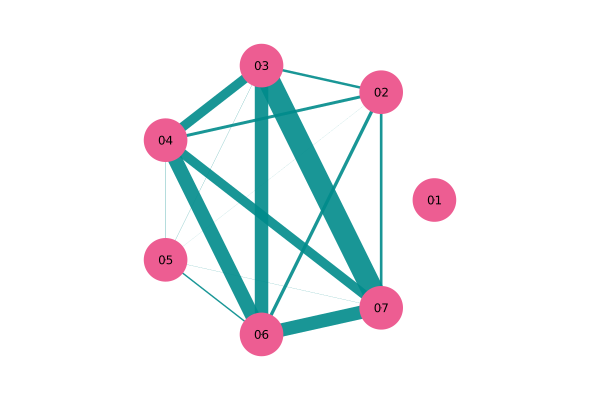

In [5]:
OrbitalGraphPlot(Ipq, multiplier=300)

In [6]:
ord = SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)

println(ord)

[5, 7, 3, 6, 4, 2, 1]


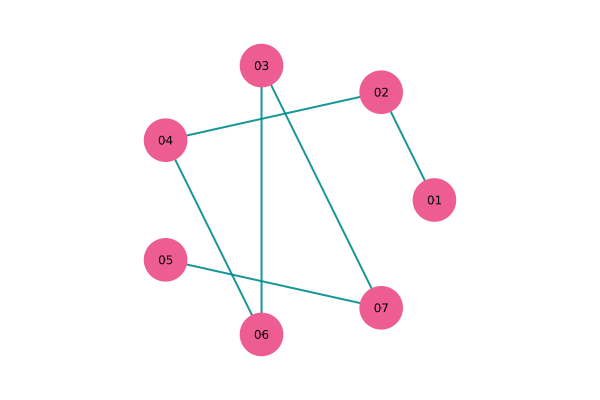

In [7]:
OrbitalGraphPlot(GraphMat(ord, directed=false), multiplier=2)

In [8]:
opsum = GenOpSum(chemical_data, ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.01889329916366
Expected particle number: 10
Particle number: 10.0


In [170]:
function ScreenOrderings(chemical_data, sites, sweeps, n_ord; maxiter=10, n_new=1, verbose=false)
    
    # Generate an initial set of orderings:
    ord_list = [randperm(chemical_data.N_spt) for i=1:n_ord]
    
    # Generate a set of states:
    psi_list, ham_list = GenStates(
        chemical_data, 
        sites, 
        ord_list, 
        sweeps, 
        ovlp_opt=false,
        perm_tol=1E-10, 
        perm_maxdim=1000, 
        ham_tol=1E-8, 
        ham_maxdim=1000, 
        spinpair=false, 
        spatial=true, 
        singleham=false,
        verbose=false
    )
    
    H_mat, S_mat = GenSubspaceMats(
        chemical_data, 
        sites, 
        ord_list, 
        psi_list,
        ham_list,
        perm_tol=1E-10, 
        perm_maxdim=1000, 
        spinpair=false, 
        spatial=true, 
        singleham=false,
        verbose=true
    );
    
    # Repeat this loop until maxiter or convergence:
    for l=1:maxiter
        
        # Get a new random ordering:
        new_ord = [randperm(chemical_data.N_spt) for i=1:n_new]
        
        # Generate the new state:
        new_psi, new_ham = GenStates(
            chemical_data, 
            sites, 
            new_ord, 
            sweeps, 
            ovlp_opt=false,
            perm_tol=1E-10, 
            perm_maxdim=1000, 
            ham_tol=1E-8, 
            ham_maxdim=1000, 
            spinpair=false, 
            spatial=true, 
            singleham=false,
            verbose=false
        )
        
        # Extend the ordering lists:
        ext_psi_list = deepcopy(psi_list)
        ext_ham_list = deepcopy(ham_list)
        ext_ord_list = deepcopy(ord_list)
        
        # Expand the subspace matrices:
        H_exp, S_exp = deepcopy(H_mat), deepcopy(S_mat)
        
        for i=1:n_new
            H_exp, S_exp = ExpandSubspaceMats(H_exp, S_exp, new_psi[i], new_ham[i], new_ord[i], ext_psi_list, ext_ord_list)
            push!(ext_psi_list, new_psi[i])
            push!(ext_ham_list, new_ham[i])
            push!(ext_ord_list, new_ord[i])
        end
        
        # Test all of the reduced subspace matrices to see which performs best:
        ids_list = collect(combinations(1:size(H_exp,1),n_new))
        e_gnd_list = []
        
        for ids in ids_list
            
            H_red, S_red = deepcopy(H_exp), deepcopy(S_exp)
            
            for k=1:length(ids)
                kmod = sum([Int(ids[k]>ids[m]) for m=1:k-1])
                jpop = ids[k]-kmod
                H_red, S_red = ShrinkSubspaceMats(H_red,S_red,jpop)
            end
            
            # Solve the GenEig problem:
            E, C, kappa = SolveGenEig(H_red, S_red, thresh="inversion", eps=1e-8)
            e_gnd = minimum(filter(!isnan,real.(E)))+chemical_data.e_nuc
            push!(e_gnd_list, e_gnd)
            
        end
        
        # Find the minimum index and remove that state:
        min_ids = ids_list[findmin(e_gnd_list)[2]]
        red_ids = setdiff(collect(1:length(ext_ord_list)),min_ids)
        
        psi_list = ext_psi_list[red_ids]
        ham_list = ext_ham_list[red_ids]
        ord_list = ext_ord_list[red_ids]
        
        H_red, S_red = deepcopy(H_exp), deepcopy(S_exp)
        
        for k=1:length(min_ids)
            kmod = sum([Int(min_ids[k]>min_ids[m]) for m=1:k-1])
            jpop = min_ids[k]-kmod
            H_red, S_red = ShrinkSubspaceMats(H_red,S_red,jpop)
        end
        
        H_mat, S_mat = H_red, S_red
        
        #println(size(H_mat))
        #println(size(S_mat))
        
        if verbose
            # Solve the GenEig problem:
            E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="inversion", eps=1e-8)
            min_eval = minimum(filter(!isnan,real.(E)))
            println("Minimum eigenvalue: ", min_eval)
        end
        
    end
    
    return psi_list, ham_list, ord_list
        
end

ScreenOrderings (generic function with 1 method)

In [194]:
sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

global_maxdim=3

opt_sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(opt_sweeps,global_maxdim) # gradually increase states kept
cutoff!(opt_sweeps,1E-10) # desired truncation error
setnoise!(opt_sweeps,1e-4,1e-6,1e-8,0.0)

noisy_sweeps = Sweeps(4) # number of sweeps is 5
maxdim!(noisy_sweeps,global_maxdim) # gradually increase states kept
cutoff!(noisy_sweeps,1E-10) # desired truncation error
setnoise!(noisy_sweeps,1e-2)

psi_list, ham_list, ord_list = ScreenOrderings(chemical_data, sites, noisy_sweeps, 13, maxiter=50, n_new=5, verbose=true);

Generating states:

Done!
computing matrix elements:
Progress: [55/55] 
Done!
Generating states:

Done!
Minimum eigenvalue: -83.84845007168087
Generating states:

Done!
Minimum eigenvalue: -83.84943268193912
Generating states:

Done!
Minimum eigenvalue: -83.85260925559344
Generating states:

Done!
Minimum eigenvalue: -83.85392982755847
Generating states:

Done!
Minimum eigenvalue: -83.85491478248231
Generating states:

Done!
Minimum eigenvalue: -83.8555376113657
Generating states:

Done!
Minimum eigenvalue: -83.8555376113657
Generating states:

Done!
Minimum eigenvalue: -83.85647254757829
Generating states:

Done!
Minimum eigenvalue: -83.85674149636945
Generating states:

Done!
Minimum eigenvalue: -83.85676274389344
Generating states:

Done!
Minimum eigenvalue: -83.85772221330346
Generating states:

Done!
Minimum eigenvalue: -83.8578664876303
Generating states:

Done!
Minimum eigenvalue: -83.8578664876303
Generating states:

Done!
Minimum eigenvalue: -83.85799937594382
Generating state

In [195]:
H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

computing matrix elements:
Progress: [55/55] 
Done!


10×10 Matrix{Float64}:
 -83.837  -83.292   82.921  -82.63   …   82.953  -83.365   82.866  -83.217
 -83.292  -83.839   82.941  -82.877      82.894  -83.336   82.89   -83.317
  82.921   82.941  -83.809   83.367     -83.692   83.232  -83.473   83.183
 -82.63   -82.877   83.367  -83.814      83.477  -83.018   83.25   -82.867
 -82.832  -82.775   83.575  -83.364      83.689  -83.225   83.461  -83.079
  83.223   83.18   -82.93    83.117  …  -83.039   83.357  -82.812   83.27
  82.953   82.894  -83.692   83.477     -83.802   83.342  -83.574   83.19
 -83.365  -83.336   83.232  -83.018      83.342  -83.819   83.267  -83.59
  82.866   82.89   -83.473   83.25      -83.574   83.267  -83.811   83.285
 -83.217  -83.317   83.183  -82.867      83.19   -83.59    83.285  -83.829

10×10 Matrix{Float64}:
  1.0     0.993  -0.989   0.985   0.988  …  -0.989   0.994  -0.988   0.993
  0.993   1.0    -0.989   0.988   0.987     -0.989   0.994  -0.989   0.994
 -0.989  -0.989   1.0    -0.995  -0.997      0.999  -0.993   0.996  -0.992
  0.985   0.988  -0.995   1.0     0.995     -0.996   0.99   -0.993   0.988
  0.988   0.987  -0.997   0.995   1.0       -0.999   0.993  -0.996   0.991
 -0.993  -0.992   0.989  -0.991  -0.989  …   0.991  -0.994   0.988  -0.993
 -0.989  -0.989   0.999  -0.996  -0.999      1.0    -0.994   0.997  -0.992
  0.994   0.994  -0.993   0.99    0.993     -0.994   1.0    -0.993   0.997
 -0.988  -0.989   0.996  -0.993  -0.996      0.997  -0.993   1.0    -0.993
  0.993   0.994  -0.992   0.988   0.991     -0.992   0.997  -0.993   1.0

Minimum eigenvalue: -83.85883288720242
Condition number: 18049.267212240797
FCI energy: -75.01927599660624
Final energy estimate: -75.01781271819151
Best single ref. estimate: -74.99806367557316
Error: 0.0014632784147323719
BSRfE: 0.02121232103307591
Improvement: 0.019749042618343537
Percentage error reduction: 93.10175245579815
Eigenvalue condition numbers: [0.0119, 0.012, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0123]
Percent correlation energy with single-geometry DMRG: 63.49303398440285
Percent correlation energy with multi-geometry TNQE: 97.48165911336646


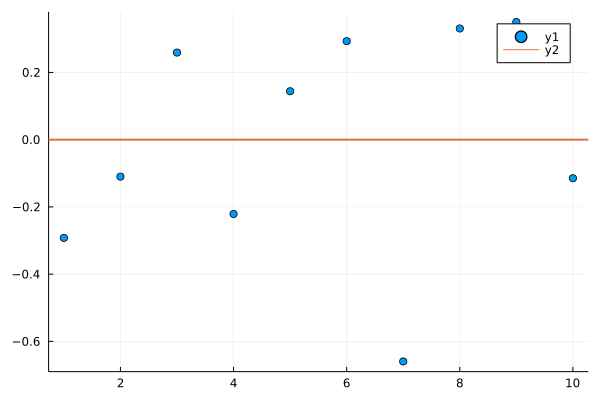

In [196]:
##### Solve the generalized eigenvalue problem:

display(round.(H_mat,digits=3))
display(round.(S_mat,digits=3))

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="inversion", eps=1e-8)

DisplayEvalData(chemical_data, E, C, kappa)

In [200]:
re_psi_list = BBOptimizeStates(
    chemical_data,
    psi_list,
    ham_list,
    ord_list;
    tol=1e-12,
    maxdim=global_maxdim,
    perm_tol=1e-12,
    perm_maxdim=5000,
    loops=2,
    sweeps=2,
    thresh="projection",
    eps=1e-8,
    verbose=true
);

Starting energy: -83.85883288724234
Run 1 of 2:

Optimizing state 1 of 10:
Sweep 1 of 2: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85883288736969
Condition number: 18049.267212245308
Sweep 2 of 2: 
Progress: [6/6]
Sweep 2 complete!
Ground state energy: -83.858907363107
Condition number: 18083.751411888188
Done!
Optimizing state 2 of 10:
Sweep 1 of 2: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85919433091237
Condition number: 15146.805319129684
Sweep 2 of 2: 
Progress: [6/6]
Sweep 2 complete!
Ground state energy: -83.85921772382684
Condition number: 15058.178819548706
Done!
Optimizing state 3 of 10:
Sweep 1 of 2: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.8594305414621
Condition number: 8900.415475960637
Sweep 2 of 2: 
Progress: [6/6]
Sweep 2 complete!
Ground state energy: -83.85944814637342
Condition number: 9107.971687655325
Done!
Optimizing state 4 of 10:
Sweep 1 of 2: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.8594

computing matrix elements:
Progress: [55/55] 
Done!


10×10 Matrix{Float64}:
  1.0     0.293  -0.442  -0.0    -0.887  …   0.99    0.995  -0.989   0.513
  0.293   1.0     0.155  -0.172  -0.297      0.303   0.331  -0.308   0.053
 -0.442   0.155   1.0     0.0     0.382     -0.429  -0.426   0.429  -0.358
 -0.0    -0.172   0.0     1.0    -0.006      0.0    -0.0    -0.0     0.0
 -0.887  -0.297   0.382  -0.006   1.0       -0.896  -0.89    0.894  -0.466
 -0.993  -0.301   0.426  -0.045   0.889  …  -0.991  -0.995   0.988  -0.521
  0.99    0.303  -0.429   0.0    -0.896      1.0     0.993  -0.997   0.52
  0.995   0.331  -0.426  -0.0    -0.89       0.993   1.0    -0.992   0.508
 -0.989  -0.308   0.429  -0.0     0.894     -0.997  -0.992   1.0    -0.548
  0.513   0.053  -0.358   0.0    -0.466      0.52    0.508  -0.548   1.0

Minimum eigenvalue: -83.85972008445171
Condition number: 3903.634931471338
FCI energy: -75.01927599660624
Final energy estimate: -75.01869991544079
Best single ref. estimate: -74.9949401947374
Error: 0.0005760811654482723
BSRfE: 0.024335801868843987
Improvement: 0.023759720703395715
Percentage error reduction: 97.63278330193096
Eigenvalue condition numbers: [0.0279, 0.116, 1.24, 2.527, 2.1759, 2.0633, 1.5573, 1.9376, 2.5005, 0.4215]
Percent correlation energy with single-geometry DMRG: 58.11744078345367
Percent correlation energy with multi-geometry TNQE: 99.00854906464727


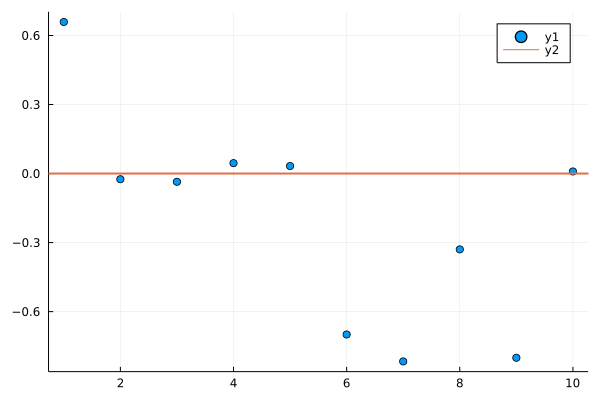

In [201]:
H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    re_psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

##### Solve the generalized eigenvalue problem:

display(round.(S_mat,digits=3))

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="none", eps=1e-9)

DisplayEvalData(chemical_data, E, C, kappa)
